# 

In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from datetime import datetime
from progressbar import ProgressBar
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
data_dir = "../data/multiclass/"
# station_filenames_list = [
#     filename for filename in os.listdir(path=data_dir)
#     if filename!=".DS_Store"
# ]

file_path = "../data/acclima_stations_id_list.txt"
acclima_stations_list = pd.read_csv(file_path, header=None).iloc[:,0].values.tolist()

In [50]:
# Load features and targets into features and targets dictionaries, indexed
# by station ID number.
template_dict = {
    test_station_id : None
    for test_station_id in acclima_stations_list
}
features_dict,targets_dict = copy.deepcopy(template_dict), copy.deepcopy(template_dict)
del(template_dict)

pbar = ProgressBar()

# for station_id in pbar(acclima_stations_list):
for station_id in acclima_stations_list:

    temp_feats_df = pd.read_pickle(
        data_dir+station_id+"_feats.pkl",
    )
    temp_feats_df.index = pd.to_datetime(temp_feats_df.index, format="%Y-%m-%d %H:%M:%S")
    features_dict[station_id] = temp_feats_df.astype(np.float64)
    
    temp_targs_df = pd.read_pickle(
        data_dir+station_id+"_targs.pkl",
    )
    print(temp_targs_df.unique())
    temp_targs_df.index = pd.to_datetime(temp_targs_df.index, format="%Y-%m-%d %H:%M:%S")
    targets_dict[station_id] = temp_targs_df

['']
['']
['']
['']
['']
['']
['']
['']
['']
['']
['']
['']
['']
['']
['' 'Acclima-Spike' 'Acclima-Noise']
['' 'Acclima-Spike']
['' 'Acclima-Spike']
['']
[]
['']
['']
['']
['']
['Acclima-NoiseAcclima-NoiseAcclima-Noise'
 'Acclima-NoiseAcclima-NoiseAcclima-NoiseAcclima-Noise'
 'Acclima-NoiseAcclima-Noise' 'Acclima-Noise' 'Acclima-SpikeAcclima-Noise'
 '']
['' 'Acclima-SpikeAcclima-SpikeAcclima-SpikeAcclima-SpikeAcclima-Spike'
 'Acclima-SpikeAcclima-SpikeAcclima-Spike']
['']
['']
['']
['']
['' 'Acclima-Spike']
['']
['']
['']
['']
['']
['' 'Acclima-Noise']
['Acclima-Noise' '']
['']
['']
['']
['']
['']
['' 'Acclima-Spike']
['']
['']
['' 'Acclima-NoiseAcclima-Noise' 'Acclima-Noise'
 'Acclima-NoiseAcclima-NoiseAcclima-Noise' 'Acclima-Spike']
['']


In [18]:
# Got the following station ID info from this URL:
# https://mesonet.agron.iastate.edu/sites/site.php?station=23906&network=USCRN
port_aransas_stat_id = "23906"
feats_df_port_aransas = features_dict[port_aransas_stat_id]
targs_df_port_aransas = targets_dict[port_aransas_stat_id]


# Got the following date-exclusion idea from here:
# https://stackoverflow.com/questions/55680603/pandas-filter-on-datetimeindex-by-excluding-date-range
exclusion_dates = pd.date_range(start="2019-08-01", end="2019-09-01")

features_dict[port_aransas_stat_id] = feats_df_port_aransas.loc[~feats_df_port_aransas.index.isin(exclusion_dates)]

targets_dict[port_aransas_stat_id] = targs_df_port_aransas.loc[~targs_df_port_aransas.index.isin(exclusion_dates)]

In [48]:
for station_id in acclima_stations_list:
    print(targets_dict[station_id].unique())

['']
['']
['']
['']
['']
['']
['']
['']
['']
['']
['']
['']
['']
['']
['']
['']
['']
['']
[]
['']
['']
['']
['']
['']
['']
['']
['']
['']
['']
['']
['']
['']
['']
['']
['']
['']
['']
['']
['']
['']
['']
['']
['']
['']
['']
['']
['']


# Explore!

In [28]:
scaled_feats_dict = {
    stat_id : None
    for stat_id in acclima_stations_list
    if features_dict[stat_id].shape[1]==15
}

pbar = ProgressBar()
for stat_id in pbar(acclima_stations_list):
    
    df_to_scale = copy.deepcopy(features_dict[stat_id]).drop(columns=["p_official", "t_official"])
    
    if (df_to_scale.shape[0]>0) and (df_to_scale.shape[1]==15):
        df_to_scale[(df_to_scale == -99999)] = pd.NA
        df_to_scale = df_to_scale.interpolate(method="time", axis=0)
        df_to_scale = df_to_scale.fillna(method="bfill", axis=0)
        scaler = StandardScaler(with_mean=True)
        feats_scaled_array = scaler.fit_transform(df_to_scale)
#         if np.isnan(feats_scaled_array).sum() == 0:
        scaled_feats_dict[stat_id] = copy.deepcopy(feats_scaled_array)
    
    else:
        continue

t = [stat_tuple[1] for stat_tuple in scaled_feats_dict.items()]
scaled_feats_array = np.concatenate(t, axis=0)

100% |########################################################################|


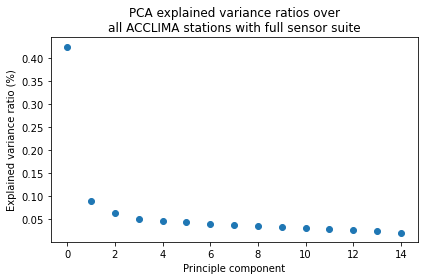

The first 3 explain 0.5785662186352186 of the variance.


In [29]:
pca = PCA()
pca_scaled_feats_array = pca.fit_transform(scaled_feats_array)
evr = pca.explained_variance_ratio_
x = [i for i in range(len(evr))]
plt.scatter(x, evr)
plt.title("PCA explained variance ratios over\nall ACCLIMA stations with full sensor suite")
plt.xlabel("Principle component")
plt.ylabel("Explained variance ratio (%)")

plt.tight_layout()
# plt.savefig("../plots/PCA_EVR_allstations_allsensors.png", dpi=300)
plt.show()
num_PC_to_sum = 3
print("The first", num_PC_to_sum, "explain", sum(evr[:num_PC_to_sum]), "of the variance.")

# Concatenate anomaly data for ML

In [31]:
for stat_id in acclima_stations_list:
    
    df_to_scale = copy.deepcopy(features_dict[stat_id]).drop(columns=["p_official", "t_official"])
    
    if (df_to_scale.shape[0]>0) and (df_to_scale.shape[1]==15):
        df_to_scale[(df_to_scale == -99999)] = pd.NA
        df_to_scale = df_to_scale.interpolate(method="time", axis=0)
        df_to_scale = df_to_scale.fillna(method="bfill", axis=0)
        scaler = StandardScaler(with_mean=True)
        feats_scaled_array = scaler.fit_transform(df_to_scale)
        feats_scaled_df = pd.DataFrame(data=feats_scaled_array, index=df_to_scale.index, columns=df_to_scale.columns)
#         if np.isnan(feats_scaled_array).sum() == 0
        scaled_feats_dict[stat_id] = copy.deepcopy(feats_scaled_df)
    else:
        continue

final_station_ids_list = [stat_id for stat_id in scaled_feats_dict.keys()]        

features_dfs_list = [scaled_feats_dict[station_id] for station_id in final_station_ids_list]
targets_dfs_list = [targets_dict[station_id] for station_id in final_station_ids_list]

scaled_feats_df = pd.concat(features_dfs_list, axis=0)
targs_df = pd.concat(targets_dfs_list, axis=0)

In [32]:
combined_scaledfeats_targs_df = pd.concat([scaled_feats_df,targs_df], axis=1)

# This takes a COUPLE MINUTES TO RUN. So, only re-run if necessary!!
# # combined_scaledfeats_targs_df.to_csv("../data/combined_scaledfeats_targs_df.csv")

In [36]:
combined_scaledfeats_targs_NONAN_df = combined_scaledfeats_targs_df.dropna(how="any", axis=0)

In [37]:
# Re-isolate the targets and then combine them into a 1-D pd.series. 
# Whenever a row has at least one anomaly, then we will collapse that row's 
# values to a single value of 1. Rows with no anomalies shall be labeled as 0.
ml_targs_df = combined_scaledfeats_targs_NONAN_df.iloc[:, -1]
# ml_1D_targs_series = ml_targs_df.sum(axis=1)
# ml_1D_targs_series[ml_1D_targs_series > 1] = 1

In [39]:
# Re-isolate the ML-ready features.
ml_feats_df = combined_scaledfeats_targs_NONAN_df.iloc[:, :15]

### Calculate the percentage of the ML-ready data that are anomalies

In [12]:
percentage_anomalies =\
    np.round(100*ml_1D_targs_series.sum()/ml_1D_targs_series.shape[0], 2)
print(f"{percentage_anomalies}% of the data are anomalies.")

11.62% of the data are anomalies.


# Attempt some ML! Yewwwwww!

In [13]:
import seaborn

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [14]:
X = ml_feats_df.values
y = ml_1D_targs_series.values

# Initialize a random forest (RF) classifier object with the best hyperparameter 
# sets from the grid search.
rf_classifier = RandomForestClassifier(n_jobs=-1)

# Initialize a stratified 5-fold cross-validation object.  Make certain that it
# randomly shuffles the data. AND, since it's randomly shuffling the data, make
# certain that its random state is set to 7 (an arbitrary choice: it simply
# needs to have a constant random state seed).
stratified_kfold_generator = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=7
)

# Iterate through each of the splits and train/test both classifiers. We will 
# store the predictions in the following lists, "classfication predictions_rf" 
# and "classfication predictions_xgb".
classification_predictions_rf = list()
for idx, (train, test) in enumerate(stratified_kfold_generator.split(X, y)):
    
    print(idx)
    
    # Fit the classifiers to the training data. This erases the training from any
    # previous iteration of the loop.
    rf_classifier.fit(X[train], y[train].ravel())

    # Have the newly trained classifiers predict the classes of the withheld testing data.
    y_predicted_rf = rf_classifier.predict(X[test])

    # Add the true class labels and the predicted class labels to the storage lists.
    classification_predictions_rf.append((y[test].ravel(), y_predicted_rf.ravel()))

0
1
2
3
4


/Users/garrettgraham/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


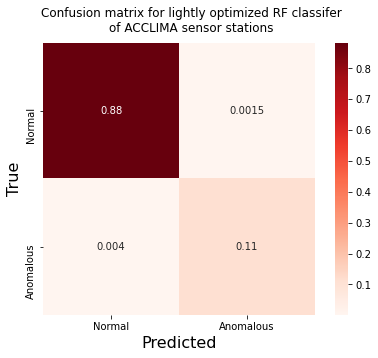

In [15]:
def calculate_normalized_conf_matrix(classification_predictions):
    cf = np.zeros((2,2))
    for y_true, y_pred in classification_predictions:
        cf += confusion_matrix(y_true, y_pred)
    return cf/cf.sum()

class_labels_list = ["Normal", "Anomalous"]

# Loop through the cached predictions and calculate the confusion matrices for
# both classifiers.
cf_rf = calculate_normalized_conf_matrix(classification_predictions_rf)

# Initialize figure and axes objects in order to plot the two confusion matrices.
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

# Plot the random forest confusion matrix.
seaborn.heatmap(
    cf_rf, cmap="Reds", annot=cf_rf, square=True, cbar=True,
    xticklabels=class_labels_list, yticklabels=class_labels_list,
    ax=ax
)

# Add labels to the x-axis and the y-axis.
ax.set_xlabel("Predicted", fontsize=16)
ax.set_ylabel("True", fontsize=16)

# Add a title to the figure.
fig.suptitle("Confusion matrix for lightly optimized RF classifer\nof ACCLIMA sensor stations")

plt.savefig("randomforest_confusion_matrix.png", dpi=300)

# Display the figure.
fig.show()

In [16]:
cf_rf

# # Previous cf_rf w/out Port Aransas filtered.
# array([[0.88232525, 0.00146891],
#        [0.00401041, 0.11219543]])

array([[0.8823122 , 0.00147708],
       [0.00401193, 0.11219878]])

In [17]:
print("Accuracy:")
print(str(np.round(100*(cf_rf[0,0]+cf_rf[1,1]), 2))+"%")

# # Previous accuracy w/out Port Aransas filtered.
# Accuracy:
# 99.45%

Accuracy:
99.45%


In [18]:
1-(cf_rf[1,0]/cf_rf[1,1])

# # Previous percentage of correctly detected anomalies w/out Port Aransas filtered.
# 0.9642551447274832

0.964242658050827